# `peak_matching.ipynb`
mTDOA works by (1) generating time delays based on the location of the target node and then (2) using those time delays to deduce the location of the target node. It is like finding the inverse of a funciton. This works, because there is only one target location that would give those time delays. With the periodic signal verion, we try to do the same thing, but we are not sure of the time delays. Since the signal is periodic, there might be multiple target locations which would give us the same signals. This is unlikely, but how would we know if it is the case? 

The goal of this file was to figure out if multiple locations in space would give the same signals. It seems unlikely, since there are N=6 values to match, but the target only has freedom in two directions. I did this by overlaying the space with points and calculating the time delays that point would give and then nudging it in the direction that would decrease the difference between calculated time delays and the real time delays. This actually turns out to solve the localization problem quite well. This file will work well as a prototype for applying this method with the FN model, which I will do in `peak_matching_fn.ipynb`.

Note: This file does not handle not knowing the phase of the root anchor, $r_1$. The method should be iterated over all phases, `0:1:0.01`.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from numba import jit
from color import *


In [2]:
@jit(nopython=True)
def dist2(r1: np.ndarray, r2: np.ndarray):
    diff = r1 - r2
    return np.dot(diff, diff)

@jit(nopython=True)
def dist(r1: np.ndarray, r2: np.ndarray):
    return np.sqrt(dist2(r1, r2))

In [3]:
@jit(nopython=True)
def get_points_frames(nodes: np.ndarray, times: np.ndarray, points: np.ndarray, frames: int, wavelength: float, period: float, epsilon: float):
    points_frames = np.empty((frames, *points.shape))
    combinatory_dxs = np.empty((frames, len(points)))
    for frame in range(frames):
        for p, point in enumerate(points):
            dx = np.zeros(2)
            combinatory_dx = 0.0
            for node, t in zip(nodes, times):
                d = dist(point, node)
                rhat = (node - point) / d
                dx_mag = np.sin(2 * np.pi * (d / wavelength - t / period))
                dx += rhat * dx_mag
                combinatory_dx += np.abs(dx_mag)
            point += epsilon * dx
            combinatory_dxs[frame, p] = epsilon * combinatory_dx
        points_frames[frame] = points
    return points_frames, combinatory_dxs


In [4]:
wavelength = 17.0
period = 11.0
speed = wavelength / period

In [5]:
N = 6
r = 20
# nodes = np.array([
#     np.power(-1+0j, 2 * i / N)
#     for i in range(N)
# ]) * r
# nodes = np.concatenate((
#     nodes.real.reshape((-1, 1)),
#     nodes.imag.reshape((-1, 1))
# ), axis=1)
# nodes += np.array([50, 50])
nodes = np.random.uniform(0, 100, size=(N, 2))

In [6]:
xs = np.arange(0, 100, 1.0)
ys = np.arange(0, 100, 1.0)
xs, ys = points = np.array(np.meshgrid(xs, ys)).reshape((2, -1))
points = points.T

In [7]:
# r0 = np.array([55, 55])
r0 = np.random.uniform(0, 100, size=2)
times = np.array([(dist(node, r0) / speed) % period for node in nodes])

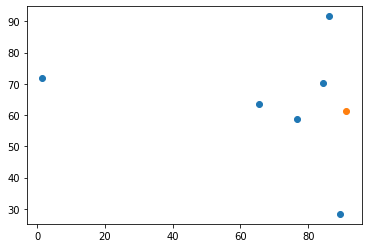

In [8]:
plt.scatter(nodes[:, 0], nodes[:, 1])
plt.scatter(*r0)

In [9]:
points_frames, combinatory_dxs = get_points_frames(nodes, times, points, 300, wavelength=wavelength, period=period, epsilon=0.1)

In [10]:
def plot_points_frame(points_frame, combinatory_dxs):
    mincd = np.nanmin(combinatory_dxs)
    maxcd = np.nanmax(combinatory_dxs)
    plt.scatter(
        points_frame[:, 0], points_frame[:, 1], s=1, 
        c=[
            interpolate_color("#1010ee", "#d4d4d4", (cd - mincd) / (maxcd - mincd)).get_hex()
            if not np.isnan(cd) else "#d4d4d4"
            for cd in combinatory_dxs
        ]
    )
    plt.scatter(
        *points_frame[np.nanargmin(combinatory_dxs)], marker='x', c="red"
    )

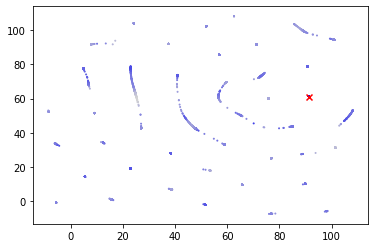

In [11]:
plot_points_frame(points_frames[-1], combinatory_dxs[-1])

In [12]:
r0, points_frames[-1, np.nanargmin(combinatory_dxs[-1])]

(array([91.26640134, 61.21347544]), array([91.26640134, 61.21347544]))

In [13]:
np.nanmin(combinatory_dxs[-1])

1.7754160106886562e-14

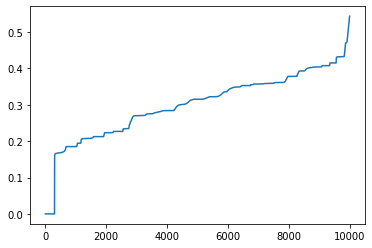

In [14]:
sorted_comb_dxs = combinatory_dxs[-1].copy()
sorted_comb_dxs.sort()
plt.plot(sorted_comb_dxs)
plt.show()